# Task 2 - LSTM for time series classification

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import re


In [0]:
sns.set_style("darkgrid")
sns.set(font_scale=1.3)

## Data import & EDA

In [84]:
files.upload() #upload the files needed with this command if you'd like. There are about 20 csv files and one for the target labels

{}

In [85]:
FILE_NAME_PREFIX = 'Ambient_Living_'
data_file_pattern = FILE_NAME_PREFIX + r'\d+.csv'
data_files = list(filter(lambda s: re.match(file_name_pattern, s) is not None, os.listdir()))
len(data_files)

75

In [0]:
def load_file(file_code, strip=False):
    df = pd.read_csv(f'{FILE_NAME_PREFIX}{file_code}.csv')
    
    if strip:
        df.columns = [c.strip() for c in df.columns]
    
    return df

### Data example

In [87]:
seq_id = 1
data_example = load_file(seq_id)
data_example.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
0,-0.90476,-0.48,0.28571,0.30
1,-0.57143,-0.32,0.14286,0.30
2,-0.38095,-0.28,-0.14286,0.35
3,-0.28571,-0.20,-0.47619,0.35
4,-0.14286,-0.20,0.14286,-0.20


In [88]:
data_example.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4
count,27.000000,27.000000,27.000000,27.000000
mean,-0.232805,-0.082963,-0.077601,0.088889
std,0.216344,0.185614,0.240700,0.299465
min,-0.904760,-0.600000,-0.619050,-0.800000
25%,-0.309520,-0.200000,-0.285710,-0.075000
50%,-0.142860,-0.040000,-0.047619,0.150000
75%,-0.095238,0.040000,0.142860,0.325000
max,0.000000,0.160000,0.285710,0.500000


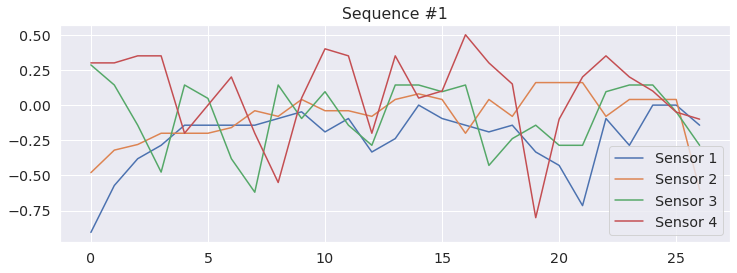

In [89]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=data_example, dashes=False)
_ = ax.set_title(f"Sequence #{seq_id}")

### Targets - class labels

In [90]:
targets = load_file('target', True)[:len(data_files)]
targets.head()

,#sequence_ID,class_label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [91]:
targets['class_label'].value_counts()  # number of classes, class labels, number of examples per class

-1    39
 1    36
Name: class_label, dtype: int64

In [0]:
all_labels = ((targets['class_label'].values + 1)/2).astype("int32")

### All data files

In [0]:
all_data = {i: load_file(i) for i in range(1, len(data_files)+1)}


In [94]:
descr = targets['class_label'].to_frame()
descr.index=targets['#sequence_ID']
descr['length'] = [d.shape[0] for d in all_data.values()]
descr['n_features'] = [d.shape[1] for d in all_data.values()]
descr.head()

,class_label,length,n_features
#sequence_ID,,,
1,1,27,4
2,1,26,4
3,1,23,4
4,1,23,4
5,1,25,4


In [95]:
descr[descr.columns[1:]].describe(percentiles=np.arange(0.2, 1, 0.2))

,length,n_features
count,75.000000,75.0
mean,25.386667,4.0
std,2.572691,0.0
min,20.000000,4.0
20%,23.000000,4.0
40%,25.000000,4.0
50%,26.000000,4.0
60%,26.000000,4.0
80%,27.000000,4.0
max,32.000000,4.0


## Pre-processing
### Adjust sequence lengths to the global 80th quantile

In [96]:
q_cut = 0.8  # cut the length at the 80th quantile
q_cut_value = int(descr['length'].quantile(q_cut))  # get the length corresponding to the quantile
q_cut_value

27

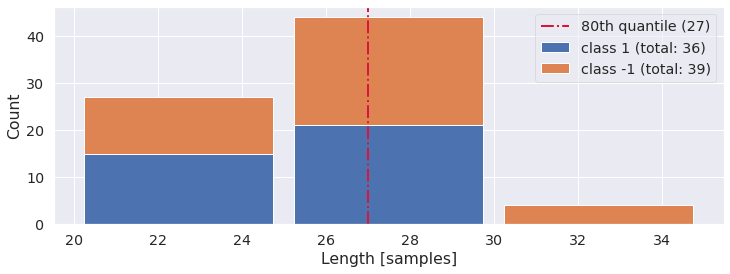

In [97]:
fig, ax = plt.subplots(figsize=(12,4))

w = 5
ln = descr['length']
labels_set = descr['class_label'].unique()
lengths_classes = [ln[descr['class_label'] == label] for label in labels_set]

hist = ax.hist(lengths_classes,
               bins=range(w*(min(ln)//w), max(ln)+w, w),
               label=[f'class {label} (total: {len(lengths_classes[i])})' for i, label in enumerate(labels_set)],
               stacked=True, rwidth=0.9)

ax.axvline(q_cut_value, color='crimson', linestyle='-.', lw=2, label=f'{100*q_cut:.0f}th quantile ({q_cut_value})')

ax.legend(fancybox=True, framealpha=0.5)
ax.set_xlabel("Length [samples]")
ax.set_ylabel("Count")
plt.show()

In [0]:
# prepare array for the pre-processed data (216x54x4)
all_data_prep = np.zeros((len(all_data), q_cut_value, all_data[1].shape[1]))

# fill the array with data for cropped sequences (the padding to 0 is automatic by non-filling the already zero-filled rows)
for i, sequence in enumerate(all_data.values()):
    all_data_prep[i, :min(q_cut_value, sequence.shape[0]), :] = sequence.iloc[:q_cut_value, :]

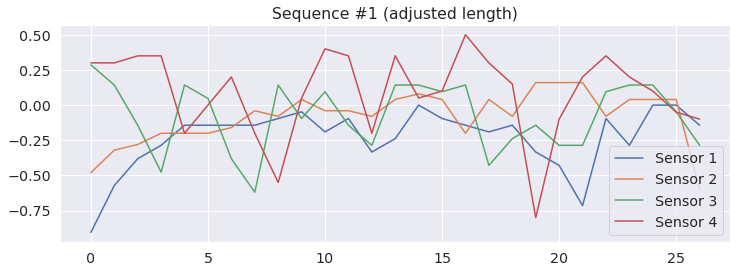

In [99]:
fig, ax = plt.subplots(figsize=(12,4))
ax = sns.lineplot(ax=ax, data=all_data_prep[0], dashes=False)
_ = ax.set_title(f"Sequence #{seq_id} (adjusted length)")
_ = ax.legend(data_example.columns)

## LSTM

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score


In [0]:
# a function defining a model to be evaluated (after wrapping by the Keras)
def make_lstm():
    lstm_model = Sequential()
    lstm_model.add(layers.LSTM(256, input_shape=all_data_prep.shape[1:]))
    lstm_model.add(layers.Dense(1, activation='sigmoid'))
    
    adam = Adam(lr=0.001)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return lstm_model

fit_params = dict(epochs=200, batch_size=128)


In [0]:
# define the 10-fold cross-validation split
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [0]:
# define a scoring function for the cross validation
def scorer(estimator, X, y):
    return accuracy_score((estimator.predict(X) > 0.5).astype("int32"), y) 


In [104]:
# run the cross-validation
scores = cross_val_score(KerasClassifier(make_lstm, **fit_params), X=all_data_prep, y=all_labels, cv=kf, scoring=scorer)


Epoch 1/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6943 - accuracy: 0.4925
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.5672
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6636 - accuracy: 0.5672
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 0.6442 - accuracy: 0.5970
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 0.6164 - accuracy: 0.6567
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5730 - accuracy: 0.7910
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 0.5064 - accuracy: 0.7761
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.7761
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3901 - accuracy: 0.8507
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 0.3736 - accuracy: 0.8657
Epoch 11/200
1/1 [===========

In [105]:
scores

array([1.        , 0.875     , 0.875     , 0.625     , 1.        ,
       0.85714286, 0.85714286, 0.85714286, 0.85714286, 1.        ])